In [2]:
from rdflib import Graph 
from rdflib.namespace import RDF, OWL
from rdflib.term import URIRef
import pprint
import networkx as nx
import matplotlib.pyplot as plt
import random

def stripURI(x):
    return x.split("/")[-1]

g = Graph()
g.parse("resources/SpeckledBand.ttl", format="turtle");

# Random Walk

## Random Walk Visualisation

In [60]:
# Graph a random walk
WALK_LENGTH = 10
subjs = list(g.subjects())
randomWalkGraph = nx.DiGraph()
edgeLabels = {}
plt.clf() # need this if using %matplotlib qt 

currentNode = random.choice(subjs)
currentNode_strip = stripURI(currentNode)
for i in range(WALK_LENGTH):
    # choose a random edge
    preds_objs = list(g.predicate_objects(subject = currentNode))
    if len(preds_objs) == 0: # nowhere to go, end walk
        break
    pred, obj = random.choice(preds_objs)
    pred_strip, obj_strip = stripURI(pred), stripURI(obj)
    print(currentNode_strip, pred_strip, obj_strip)
    randomWalkGraph.add_edge(currentNode_strip, obj_strip)
    edgeLabels[(currentNode_strip, obj_strip)] = pred_strip
    
    currentNode = obj
    currentNode_strip = stripURI(currentNode)

%matplotlib qt
pos = nx.spring_layout(randomWalkGraph)
nx.draw_networkx(randomWalkGraph, pos=pos)
nx.draw_networkx_edge_labels(randomWalkGraph, pos=pos, edge_labels=edgeLabels)
plt.show()
# sometimes freaks out when it tries to render kanji/hirigana/katakana
    

floor_of_bedroom_of_Julia rdf-schema#label floor of bedroom of Julia


### Example of  Random Walk
![yeet](resources/Figure_1.png)

## Random Walk with Analytics

In [50]:
def random_walk(g, walk_length):
    '''
        Performs random walk over rdflib graph. Returns 2-tuple of lists (nodes_traversed, edges_traversed)
        g::rdflib graph 
        walk_length::positive_int
    '''
    subjs = list(g.subjects())
    currentNode = random.choice(subjs)
    nodes_traversed = [currentNode]
    edges_traversed = [] 
    for i in range(walk_length):
        preds_objs = list(g.predicate_objects(subject = currentNode))
        if len(preds_objs) == 0: # nowhere to go, end walk
            break
        pred, obj = random.choice(preds_objs)
        nodes_traversed.append(obj)
        edges_traversed.append(pred)
        currentNode = obj
    return (nodes_traversed, edges_traversed)    

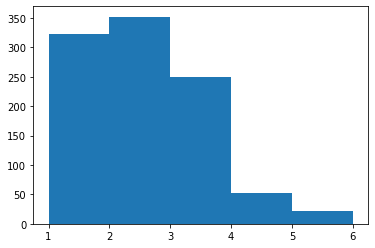

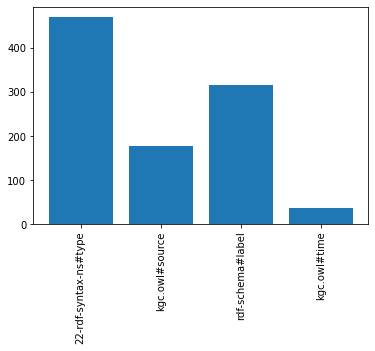

In [57]:
walk_lengths = []
final_edges = {}
for x in range(1000):
    rw_nodes, rw_edges = random_walk(g, 50)
    walk_lengths.append(len(rw_edges))
    
    final_edge = stripURI(rw_edges[-1])
    if final_edge in final_edges:
        final_edges[final_edge] += 1
    else:
        final_edges[final_edge] = 1

# histogram of walk lengths    
num_bins = 5
fig, ax = plt.subplots()
n, bins, patches = ax.hist(walk_lengths, num_bins)
plt.show()

# distribution of final edges
x = final_edges.keys()
y = [final_edges[i] for i in x]
plt.xticks(rotation='vertical')
plt.bar(x,y)
plt.show()

In [13]:
# Show all show all edges which are encoded with "Then"
thenG = nx.DiGraph()
for s, p, o in g.triples((None,
    URIRef("http://kgc.knowledge-graph.jp/ontology/kgc.owl#then"),
    None)): 
    # Idea: do query to get better node names
    thenG.add_edge(stripURI(s), stripURI(o))

%matplotlib qt
nx.draw_networkx(thenG)
plt.show()

No handles with labels found to put in legend.


# Various Graph Analytics

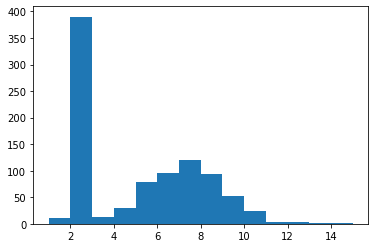

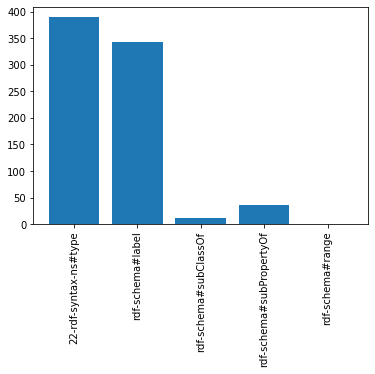

In [48]:
# Various Graph statistics

# Average degree
degrees = {}
total = 0
for subj in g.subjects():
    d = len(list(g.predicate_objects(subject=subj)))
    degrees[subj] = d
    total += d
#print(total / len(list(g.subjects())))

# plot degrees
num_bins = 14
fig, ax = plt.subplots()
# the histogram of the data
n, bins, patches = ax.hist(degrees.values(), num_bins)
plt.show()

# most nodes have degree 2, let's see what these edges are
twoEdges = {}
for node in degrees:
    if degrees[node] == 2:
        edges = g.predicates(subject=node)
        for e in edges:
            edge = stripURI(e)
            if edge in twoEdges.keys():
                twoEdges[edge] += 1
            else:
                twoEdges[edge] = 1
x = list(twoEdges.keys())
y = [twoEdges[i] for i in x]
plt.xticks(rotation='vertical')
plt.bar(x,y)
plt.show()

# most nodes are have "type" ad "label" attached to them, which makes sense.

# Some "Attempt" on Multilayer-stuffs (stills need some refinement)


In [ ]:
#checking possibles predicates
pred = list(g.predicates())
refinedpred = {}
for entry in pred:
    if entry in refinedpred.keys():
        refinedpred[entry] += 1
    else:
        refinedpred[entry] = 1
layer = list(refinedpred.keys())
layer2  = []
for l in layer:
    layer2.append(stripURI(l))
print(layer2)

In [ ]:
#check the subject that is not the scene ID

strcheck = [] 
for i in range(500):
    strcheck.append(str(i))
strcheck.append("T184") #these two random id are kind of errors in the original knowledge graph
strcheck.append("T186")

sub = list(g.subjects())
subject = {}
for entry in sub:
    if entry in subject.keys():
        subject[entry] += 1
    else:
        subject[entry] = 1
realsubject = list(subject.keys())
realsubject_exclude_sceneid  = []
for l in realsubject:
    l2 = stripURI(l)
    if l2 not in strcheck:
        realsubject_exclude_sceneid.append(l2)
print(realsubject_exclude_sceneid)

In [ ]:
#let's try to extract the predicate away and forgetting all the scene ID
from pymnet import * #get the library from https://bitbucket.org/bolozna/multilayer-networks-library/src/default/ 
net = MultilayerNetwork(aspects = 1)
querylist = [1] #use the index from previous cell, the network has too high resolution to create all layer at the same time
for i in querylist:
    net.add_layer(i)
    subs_objs = list(g.subject_objects(predicate = layer[i]))
    for s,o in subs_objs:
        if stripURI(s) not in strcheck and stripURI(o) not in strcheck:
            net[stripURI(s),i][stripURI(o),i] = 1
        
fig = draw(net, show=True,
             layerColorRule={},
             defaultLayerColor="gray",
             edgeColorRule={"rule":"edgeweight","colormap":"jet","scaleby":0.1}
             )
fig.savefig("net.pdf")
# This seems like a bad choice, as all interesting stuffs disappear.